# Protein Sequence Classification: Sequence Similarity

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tqdm import tqdm
import random

import tensorflow as tf
# tf.config.run_functions_eagerly(True)
import torch


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# To ensure reproducibility
# for keras operations that use random numbers internally
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Loading cleaned protein sequence data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
protein_data = pd.read_csv('pdb_protein_seq_clean.csv')
# protein_data.head()

In [11]:
# Verify if there are any NaN or whitespace-only sequences
print("Initial data shape:", protein_data.shape)
print("Number of missing sequences:", protein_data['clean_sequence'].isna().sum())
print("Number of sequences that are whitespace-only:", (protein_data['clean_sequence'].str.strip() == '').sum())

Initial data shape: (138261, 6)
Number of missing sequences: 484
Number of sequences that are whitespace-only: 0


In [12]:
# Drop any rows with missing or whitespace-only sequences
protein_data = protein_data.dropna(subset=['clean_sequence'])  # Remove rows where sequence is NaN
protein_data = protein_data[protein_data['clean_sequence'].str.strip() != '']  # Remove rows with whitespace-only sequences

# Ensure all entries are strings
protein_data['clean_sequence'] = protein_data['clean_sequence'].astype(str).str.strip()  # Ensure sequences are strings and stripped of whitespace

# Verify the cleaned data
print("Cleaned data shape:", protein_data.shape)
print("Number of missing sequences after cleaning:", protein_data['clean_sequence'].isna().sum())

Cleaned data shape: (137777, 6)
Number of missing sequences after cleaning: 0


In [9]:
protein_data

,structureId,classification,macromoleculeType,sequence,seq_char_count,clean_sequence
0,101M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,hydrolase,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3,103L,hydrolase,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4,103M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
...,...,...,...,...,...,...
138256,9LYZ,hydrolase,Protein,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...,129,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...
138257,9NSE,oxidoreductase,Protein,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...,444,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...
138258,9PAI,hydrolase inhibitor,Protein,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...,346,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...
138259,9PAI,hydrolase inhibitor,Protein,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,33,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP


In [ ]:
protein_data['id'] = protein_data.index

In [13]:
# Load the protein dataset
# protein_data = pd.read_csv("clustered_data_90_new.csv")  # Ensure it has 'pdb_id' column

# Load the ECOD file and extract relevant columns
ecod_data = pd.read_csv(".ECOD/ecod.latest.domains.txt", sep="\t", skiprows=4, dtype=str) # usecols=["pdb", "f_name"],



In [ ]:
ecod_data

,#uid,ecod_domain_id,manual_rep,f_id,pdb,chain,pdb_range,seqid_range,unp_acc,arch_name,x_name,h_name,t_name,f_name,asm_status,ligand
0,003026368,e8ci7A1,AUTO_NONREP,1.1.1,8ci7,A,A:1-99,A:1-99,NO_UNP,beta barrels,cradle loop barrel,RIFT-related,acid protease,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1,003022099,e8cikA1,AUTO_NONREP,1.1.1,8cik,A,A:150-323,A:150-323,NO_UNP,beta barrels,cradle loop barrel,RIFT-related,acid protease,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
2,003022100,e8cikA2,AUTO_NONREP,1.1.1,8cik,A,A:1-149,A:1-149,NO_UNP,beta barrels,cradle loop barrel,RIFT-related,acid protease,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
3,000143792,e3s8iA1,MANUAL_REP,1.1.1.3,3s8i,A,A:241-367,A:22-148,Q8WTU0,beta barrels,cradle loop barrel,RIFT-related,acid protease,Asp_protease,NOT_DOMAIN_ASSEMBLY,"EDO,PO4,UNX"
4,000162272,e2i1aA1,AUTO_NONREP,1.1.1.3,2i1a,A,A:200-324,A:23-147,P40087,beta barrels,cradle loop barrel,RIFT-related,acid protease,Asp_protease,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027100,002773383,e6exnc2,AUTO_NONREP,7101.1.1,6exn,c,c:246-345,c:246-345,NO_UNP,extended segments,NO_X_NAME,NO_H_NAME,Prp8-binding region of SLU7,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1027101,002815581,e6bk8O2,AUTO_NONREP,7101.1.1,6bk8,O,O:246-347,O:246-347,NO_UNP,extended segments,NO_X_NAME,NO_H_NAME,Prp8-binding region of SLU7,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1027102,002526321,e6iczZ2,MANUAL_REP,7101.1.1.1,6icz,Z,Z:265-371,Z:265-371,O95391,extended segments,NO_X_NAME,NO_H_NAME,Prp8-binding region of SLU7,EUF07867,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1027103,002589230,e5xjcZ2,AUTO_NONREP,7101.1.1.1,5xjc,Z,Z:265-371,Z:265-371,NO_UNP,extended segments,NO_X_NAME,NO_H_NAME,Prp8-binding region of SLU7,EUF07867,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A


In [ ]:
ecod_data.duplicated().sum()

0

In [14]:
# Remove the leading '#' from the header column names, if present
ecod_data.columns = [col.lstrip("#").strip() for col in ecod_data.columns]
ecod_data['pdb'] = ecod_data['pdb'].str.upper()
# Display the first few rows to verify
ecod_data

,uid,ecod_domain_id,manual_rep,f_id,pdb,chain,pdb_range,seqid_range,unp_acc,arch_name,x_name,h_name,t_name,f_name,asm_status,ligand
0,003026368,e8ci7A1,AUTO_NONREP,1.1.1,8CI7,A,A:1-99,A:1-99,NO_UNP,beta barrels,cradle loop barrel,RIFT-related,acid protease,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1,003022099,e8cikA1,AUTO_NONREP,1.1.1,8CIK,A,A:150-323,A:150-323,NO_UNP,beta barrels,cradle loop barrel,RIFT-related,acid protease,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
2,003022100,e8cikA2,AUTO_NONREP,1.1.1,8CIK,A,A:1-149,A:1-149,NO_UNP,beta barrels,cradle loop barrel,RIFT-related,acid protease,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
3,000143792,e3s8iA1,MANUAL_REP,1.1.1.3,3S8I,A,A:241-367,A:22-148,Q8WTU0,beta barrels,cradle loop barrel,RIFT-related,acid protease,Asp_protease,NOT_DOMAIN_ASSEMBLY,"EDO,PO4,UNX"
4,000162272,e2i1aA1,AUTO_NONREP,1.1.1.3,2I1A,A,A:200-324,A:23-147,P40087,beta barrels,cradle loop barrel,RIFT-related,acid protease,Asp_protease,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027100,002773383,e6exnc2,AUTO_NONREP,7101.1.1,6EXN,c,c:246-345,c:246-345,NO_UNP,extended segments,NO_X_NAME,NO_H_NAME,Prp8-binding region of SLU7,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1027101,002815581,e6bk8O2,AUTO_NONREP,7101.1.1,6BK8,O,O:246-347,O:246-347,NO_UNP,extended segments,NO_X_NAME,NO_H_NAME,Prp8-binding region of SLU7,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1027102,002526321,e6iczZ2,MANUAL_REP,7101.1.1.1,6ICZ,Z,Z:265-371,Z:265-371,O95391,extended segments,NO_X_NAME,NO_H_NAME,Prp8-binding region of SLU7,EUF07867,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1027103,002589230,e5xjcZ2,AUTO_NONREP,7101.1.1.1,5XJC,Z,Z:265-371,Z:265-371,NO_UNP,extended segments,NO_X_NAME,NO_H_NAME,Prp8-binding region of SLU7,EUF07867,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A


In [15]:
# Drop duplicates from ecod_data if multiple rows per pdb exist
ecod_data = ecod_data.drop_duplicates(subset=['pdb'])
ecod_data

,uid,ecod_domain_id,manual_rep,f_id,pdb,chain,pdb_range,seqid_range,unp_acc,arch_name,x_name,h_name,t_name,f_name,asm_status,ligand
0,003026368,e8ci7A1,AUTO_NONREP,1.1.1,8CI7,A,A:1-99,A:1-99,NO_UNP,beta barrels,cradle loop barrel,RIFT-related,acid protease,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1,003022099,e8cikA1,AUTO_NONREP,1.1.1,8CIK,A,A:150-323,A:150-323,NO_UNP,beta barrels,cradle loop barrel,RIFT-related,acid protease,F_UNCLASSIFIED,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
3,000143792,e3s8iA1,MANUAL_REP,1.1.1.3,3S8I,A,A:241-367,A:22-148,Q8WTU0,beta barrels,cradle loop barrel,RIFT-related,acid protease,Asp_protease,NOT_DOMAIN_ASSEMBLY,"EDO,PO4,UNX"
4,000162272,e2i1aA1,AUTO_NONREP,1.1.1.3,2I1A,A,A:200-324,A:23-147,P40087,beta barrels,cradle loop barrel,RIFT-related,acid protease,Asp_protease,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
9,001738446,e4rghA1,AUTO_NONREP,1.1.1.3,4RGH,A,A:200-327,A:41-168,Q5TDH0,beta barrels,cradle loop barrel,RIFT-related,acid protease,Asp_protease,NOT_DOMAIN_ASSEMBLY,CL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025158,001548123,e2mvhA1,MANUAL_REP,3963.1.1.1,2MVH,A,A:1-26,A:1-26,P37817,extended segments,NO_X_NAME,NO_H_NAME,Stage V sporulation protein M,SpoV,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1025159,001550126,e2mvjA1,AUTO_NONREP,3963.1.1.1,2MVJ,A,A:1-26,A:1-26,P37817,extended segments,NO_X_NAME,NO_H_NAME,Stage V sporulation protein M,SpoV,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1025440,001824195,e2n7qA1,AUTO_NONREP,1028.1.1.2,2N7Q,A,A:1-46,A:9-54,Q92542,extended segments,NO_X_NAME,NO_H_NAME,Nicastrin transmembrane helix,KOG2657_like,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A
1025441,001824196,e2n7rA1,AUTO_NONREP,1028.1.1.2,2N7R,A,A:1-46,A:9-54,Q92542,extended segments,NO_X_NAME,NO_H_NAME,Nicastrin transmembrane helix,KOG2657_like,NOT_DOMAIN_ASSEMBLY,NO_LIGANDS_4A


In [16]:
f_name_df = ecod_data[['pdb', 'f_name']]

# Merge ECOD family names into the protein dataset
protein_data = protein_data.merge(f_name_df, left_on="structureId", right_on="pdb", how="left")

# Rename and drop unnecessary columns
protein_data = protein_data.rename(columns={"f_name": "ecod_family"}).drop(columns=["pdb"])

# Display the first few rows to verify
protein_data

,structureId,classification,macromoleculeType,sequence,seq_char_count,clean_sequence,ecod_family
0,101M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,Globin
1,102L,hydrolase,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,Phage_lysozyme_2
2,102M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,Globin
3,103L,hydrolase,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,Phage_lysozyme_2
4,103M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,Globin
...,...,...,...,...,...,...,...
137772,9LYZ,hydrolase,Protein,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...,129,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...,Lys
137773,9NSE,oxidoreductase,Protein,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...,444,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...,NO_synthase
137774,9PAI,hydrolase inhibitor,Protein,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...,346,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...,Serpin
137775,9PAI,hydrolase inhibitor,Protein,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,33,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,Serpin


In [19]:
# Save the updated dataset
protein_data.to_csv("protein_dataset_with_ecod.csv", index=False)

In [20]:
print(len(protein_data['ecod_family'].unique()))

8020


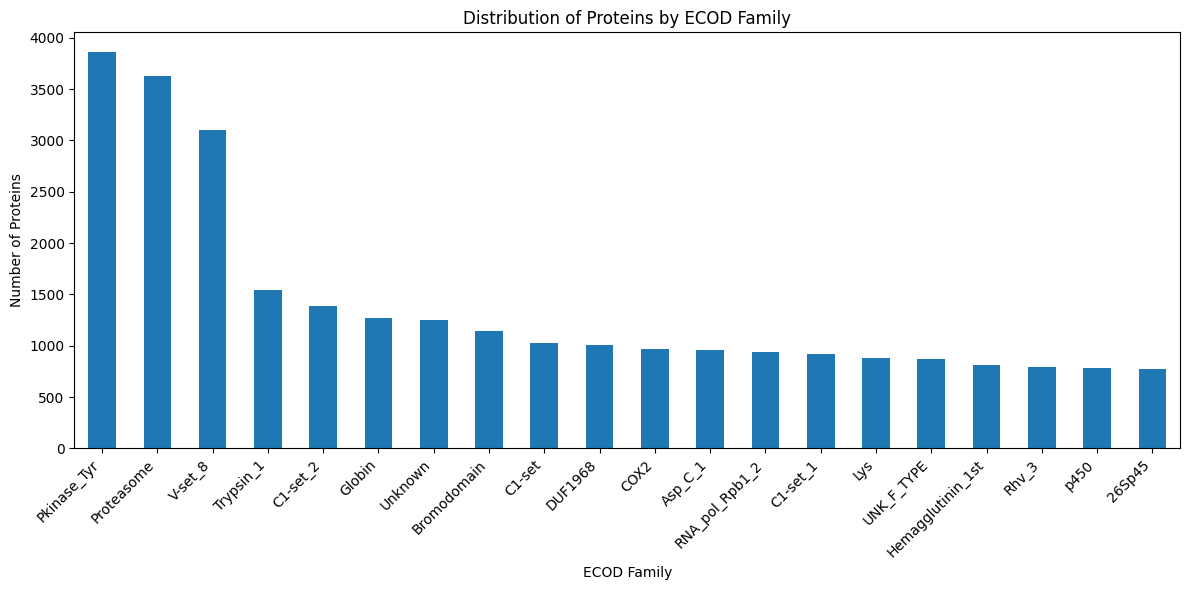

In [21]:
# If needed, fill missing values in ecod_family (optional)
protein_data["ecod_family"] = protein_data["ecod_family"].fillna("Unknown")

# Group by ecod_family and count the number of sequences in each family
family_counts = protein_data.groupby("ecod_family").size().sort_values(ascending=False)

# Plot a bar chart of the top 20 ECOD families (or all, if you prefer)
plt.figure(figsize=(12, 6))
family_counts.head(20).plot(kind="bar")
plt.xlabel("ECOD Family")
plt.ylabel("Number of Proteins")
plt.title("Distribution of Proteins by ECOD Family")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [39]:
from sklearn.model_selection import train_test_split

# Step 1: Split by ECOD families (to prevent homologous proteins in both sets)
train_ecod, test_ecod = train_test_split(
    protein_data['ecod_family'].unique(), test_size=0.1, random_state=42
)

train_ecod, val_ecod = train_test_split(
    train_ecod, test_size=0.2, random_state=42
)

# Assign sequences based on ECOD superfamily split
train_data = protein_data[protein_data['ecod_family'].isin(train_ecod)]
val_data = protein_data[protein_data['ecod_family'].isin(val_ecod)]
test_data = protein_data[protein_data['ecod_family'].isin(test_ecod)]

# # Step 2: Further Stratify Within Train & Test Sets by Class Labels
# train_data, val_data = train_test_split(train_data, test_size=0.1, stratify=train_data['classification'], random_state=42)

# Reset Index
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Print dataset sizes
print("Train Size:", train_data.shape)
print("Validation Size:", val_data.shape)
print("Test Size:", test_data.shape)

# print("""Train Size: (81962, 7)
# Validation Size: (43320, 7)
# Test Size: (12473, 7)
# """)


Train Size: (95803, 7)
Validation Size: (26098, 7)
Test Size: (15876, 7)


In [40]:
print(len(train_data['classification'].unique()))
print(len(val_data['classification'].unique()))
print(len(test_data['classification'].unique()))

74
75
70


In [41]:
# Extract unique classifications from train and test datasets
train_classes = set(train_data['classification'].unique())
val_classes = set(val_data['classification'].unique())
test_classes = set(test_data['classification'].unique())

# Find classes that are in the test set but not in the train set
missing_in_train = val_classes - train_classes

# Find classes that are in the test set but not in the train set
missing_in_test = val_classes - test_classes

print("Classes present in val but not in train:", missing_in_train)

print("Classes present in train but not in test:", missing_in_test)

Classes present in val but not in train: {'biotin-binding protein'}
Classes present in train but not in test: {'luminescent protein', 'biotin-binding protein', 'hormone receptor', 'immunoglobulin', 'oxygen storage'}


In [42]:
# For each missing class, move a subset of rows from train to test
rows_to_move = []  # to collect indices from train to move to test

for cl in missing_in_train:
    # Select all rows for the missing class (or use .head(n) to move only a few)
    class_rows = val_data[val_data['classification'] == cl]

    # Optionally, choose only a subset if there are many; for example, 1 row:
    subset = class_rows.head(20)

    # Append the indices to move
    rows_to_move.extend(subset.index.tolist())

# Move these rows: add them to test_data_ecod and remove from train_data_ecod
train_data = pd.concat([train_data, val_data.loc[rows_to_move]], ignore_index=True)
val_data = val_data.drop(rows_to_move)

# Verify the update
print(len(train_data['classification'].unique()))
print(len(val_data['classification'].unique()))
new_train_classes = set(train_data['classification'].unique())
new_val_classes = set(val_data['classification'].unique())
print("Updated train classes:", new_train_classes)
print("Updated test classes:", new_val_classes)

75
75
Updated train classes: {'immune system', 'toxin', 'ligase inhibitor', 'transcription inhibitor', 'oxidoreductase inhibitor', 'translation', 'peptide binding protein', 'endocytosis', 'hydrolase', 'membrane protein', 'flavoprotein', 'transferase inhibitor', 'transcription', 'transferase', 'calcium-binding protein', 'luminescent protein', 'ribosome', 'blood clotting', 'sugar binding protein', 'cell cycle', 'virus', 'contractile protein', 'antibiotic transferase', 'plant protein', 'unknown function', 'nuclear protein', 'de novo protein', 'fluorescent protein', 'phosphotransferase', 'chaperone', 'antibiotic hydrolase', 'motor protein', 'ribosomal protein', 'lectin', 'oxidoreductase', 'gene regulation', 'lyase inhibitor', 'biosynthetic protein', 'isomerase', 'isomerase inhibitor', 'structural protein', 'hormone receptor', 'electron transport', 'receptor', 'hormone', 'lyase', 'cell invasion', 'lipid binding protein', 'immunoglobulin', 'splicing', 'transport protein', 'hydrolase inhibito

In [43]:
# For each missing class, move a subset of rows from train to test
rows_to_move = []  # to collect indices from train to move to test

for cl in missing_in_test:
    # Select all rows for the missing class (or use .head(n) to move only a few)
    class_rows = train_data[train_data['classification'] == cl]

    # Optionally, choose only a subset if there are many; for example, 1 row:
    subset = class_rows.head(5)

    # Append the indices to move
    rows_to_move.extend(subset.index.tolist())

# Move these rows: add them to test_data_ecod and remove from train_data_ecod
test_data = pd.concat([test_data, train_data.loc[rows_to_move]], ignore_index=True)
train_data = train_data.drop(rows_to_move)

# Verify the update
print(len(train_data['classification'].unique()))
print(len(test_data['classification'].unique()))
new_train_classes = set(train_data['classification'].unique())
new_test_classes = set(test_data['classification'].unique())
print("Updated train classes:", new_train_classes)
print("Updated test classes:", new_test_classes)



75
75
Updated train classes: {'immune system', 'toxin', 'ligase inhibitor', 'transcription inhibitor', 'oxidoreductase inhibitor', 'translation', 'peptide binding protein', 'endocytosis', 'hydrolase', 'membrane protein', 'flavoprotein', 'transferase inhibitor', 'transcription', 'transferase', 'calcium-binding protein', 'ribosome', 'blood clotting', 'cell cycle', 'sugar binding protein', 'luminescent protein', 'virus', 'contractile protein', 'antibiotic transferase', 'plant protein', 'unknown function', 'nuclear protein', 'de novo protein', 'fluorescent protein', 'phosphotransferase', 'chaperone', 'antibiotic hydrolase', 'motor protein', 'ribosomal protein', 'lectin', 'oxidoreductase', 'gene regulation', 'lyase inhibitor', 'biosynthetic protein', 'isomerase', 'isomerase inhibitor', 'structural protein', 'hormone receptor', 'electron transport', 'receptor', 'hormone', 'lyase', 'cell invasion', 'lipid binding protein', 'immunoglobulin', 'splicing', 'transport protein', 'hydrolase inhibito

In [44]:
# Print dataset sizes
print("Train Size:", train_data.shape)
print("Validation Size:", val_data.shape)
print("Test Size:", test_data.shape)

Train Size: (95798, 7)
Validation Size: (26078, 7)
Test Size: (15901, 7)


In [ ]:
# Save the datasets
train_data.to_csv("train_new_ecod.csv", index=False)
val_data.to_csv("val_new_ecod.csv", index=False)
test_data.to_csv("test_new_ecod.csv", index=False)

In [45]:
print(len(train_data['ecod_family'].unique()))
print(len(val_data['ecod_family'].unique()))
print(len(test_data['ecod_family'].unique()))

# Example: Identify unique classes in train and test sets
train_ecod = set(train_data['ecod_family'].unique())
val_ecod = set(val_data['ecod_family'].unique())
test_ecod = set(test_data['ecod_family'].unique())

# print(train_ecod)
# print(val_ecod)
# print(test_ecod)

# missing_in_test = train_ecod - test_ecod
# print("ECOD family missing in test set:", len(missing_in_test))

5775
1444
810
